# EMG recording

## Experiment 1: Large muscle experiment with dry and wet electrode

In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np

import scipy as sp
from scipy import signal

In [2]:
def read_wave(file_name):
    file = wave.open(file_name,'rb')
    params = file.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
#     print("nchannels:", nchannels)
#     print("sampwidth:", sampwidth)
#     print("framerate:", framerate)
#     print("nframes:", nframes)
    strData = file.readframes(nframes)  # encoded in bytes
    file.close()
    waveData = np.frombuffer(strData, dtype=np.int16)  # convert to int16
    return waveData, framerate, nframes


def plot_wave(signal, framerate, title):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    plt.figure(figsize=(6, 3))
    plt.plot(time, signal)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid('on')
    plt.savefig('./Experiment1_fig/{}.png'.format(title))
    plt.show()

In [3]:
def specgram_wave(signal, framerate):
    plt.specgram(signal, Fs=framerate, cmap="rainbow")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title("Spectrogram")
    plt.savefig('./Experiment1_fig/Spectrogram.png')
    plt.show()

In [4]:
def psd_wave(signal, framerate):
    plt.psd(signal, Fs=framerate)
    plt.savefig('./Experiment1_fig/psd.png')
    plt.show()

In [5]:
# Fast Fourier Transform at selected time interval
def fft_wave(signal, framerate, time_interval):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    
    plt.subplot(2,1,1)
    plt.plot(time, signal)
    plt.fill_between(time_interval,np.min(signal),np.max(signal),color="pink")
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.grid('on')
    
    
    start_time, end_time = time_interval
#     start_index = np.where(time == start_time)
    select_time = time[(time>=start_time) & (time<=end_time)]
    select_signal = signal[(time>=start_time) & (time<=end_time)]
    fft_signal = np.fft.fft(select_signal)
    
    t = np.arange(select_signal.size)
    freq = np.fft.fftfreq(t.shape[-1])
    freq_in_Hz = abs(freq * framerate)
    
    plt.subplot(2,1,2)
    plt.plot(freq_in_Hz,np.abs(fft_signal))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (a.u.)")
    
#     fft_signal = np.abs(fft_signal)
#     freq_in_Hz = np.fft.fftfreq(select_signal.size,1/framerate)
#     plt.plot(freq_in_Hz[0:select_signal.size//2], (2/select_signal.size)*fft_signal[0:select_signal.size//2])
    
    plt.show()
    return fft_signal, freq_in_Hz

In [6]:
# remove DC component
def remove_mean(signal):
    return signal - np.mean(signal)

# rectified
def rectified(signal):
    return np.abs(signal)

# 4th order bandpass filter
def bandpass_filter(signal, framerate, low, high):
    b, a = sp.signal.butter(4, [low/(framerate/2), high/(framerate/2)], btype='bandpass')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# 4th order bandstop filter
def bandstop_filter(signal, framerate, low, high):
    b, a = sp.signal.butter(4, [low/(framerate/2), high/(framerate/2)], btype='bandstop')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# 4th order lowpass filter
def lowpass_filter(signal, framerate, cutoff):
    b, a = sp.signal.butter(4, cutoff/(framerate/2), btype='lowpass')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

In [7]:
def wave_peaks(signal, framerate, peak_heigh):
    peaks = sp.signal.find_peaks(signal,height=peak_heigh)
    return peaks[0]

def signal_to_noise_ratio(signal, framerate, peak_heigh, rest_interval):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    signal_peaks_index = wave_peaks(signal, framerate, peak_heigh)
    
    start_rest, end_rest = rest_interval
    rest_signal = signal[(time>=start_rest) & (time<=end_rest)]
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(time, signal)
    for i in signal_peaks_index:
        plt.scatter(time[i], signal[i])
    plt.fill_between(rest_interval,np.min(signal),peak_heigh,color="grey")
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.grid('on')
    plt.show()
    
    
    signal_mean_amp = np.mean(signal[signal_peaks_index])
    noise_mean_amp = np.mean(rest_signal)
    
    SNR = (signal_mean_amp/noise_mean_amp)**2
    SNR_db = 10*np.log10(SNR)
    return SNR_db

In [8]:
def main(file_name, signal_interval=[0,1], rest_interval=[0,1], peak_height=150):
    signal, framerate, nframes = read_wave(file_name)
    
    signal_filtered = bandpass_filter(signal, framerate, 20, 450)
    signal_rectified = rectified(signal_filtered)
    signal_box = lowpass_filter(signal_rectified,framerate, 2)

    plot_wave(signal, framerate, "raw data")
    specgram_wave(signal, framerate)
    psd_wave(signal, framerate)
#     fft_wave(signal,framerate,signal_interval)
    plot_wave(signal_filtered, framerate, "filtered")
    plot_wave(signal_rectified, framerate, "rectified")
    plot_wave(signal_box, framerate, "box")
#     fft_wave(signal_filtered,framerate,signal_interval)
#     psd_wave(signal_filtered, framerate)


    
    SNR = signal_to_noise_ratio(signal_box, framerate, peak_height, rest_interval)
    print("SNR(db): ", np.round(SNR,2))

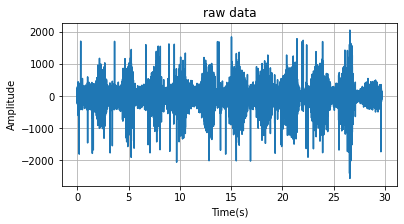

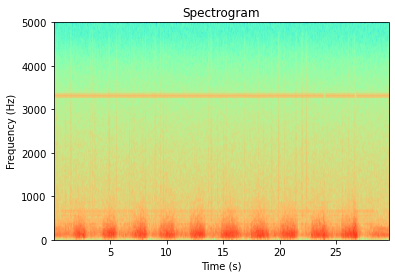

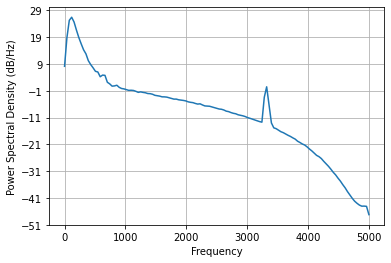

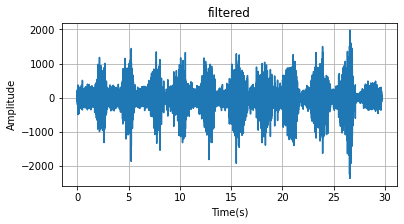

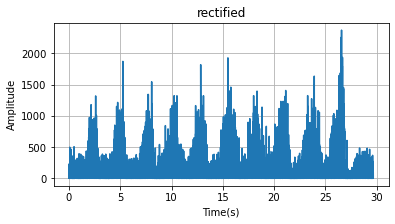

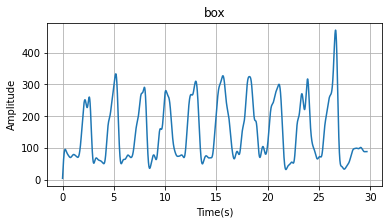

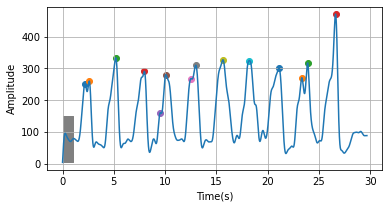

SNR(db):  11.93


In [9]:
main("实验1-湿棒02.wav", signal_interval=[0,30], rest_interval=[0,1], peak_height=150)